# CPI Analysis

### next release: 11/10

Format the following cells: 

In [1]:
# Set up the default parameters
# 1. The code block will be shown in the document
# 2. set up figure display size
# 3. turn off all the warnings and messages

knitr::opts_chunk$set(echo = TRUE)
knitr::opts_chunk$set(fig.width = 18, fig.height = 7)
knitr::opts_chunk$set(warning = FALSE, message = FALSE)

Load in packages

In [3]:
library(lubridate, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(tsbox, quietly = TRUE)
library(mgcv, warn.conflicts = FALSE, quietly = TRUE)
library(rugarch, quietly = TRUE, warn.conflicts = FALSE)
library(forecast, quietly = TRUE)
library(xts, quietly = TRUE)

In [4]:
# define a function that will  calculate the percent change of a time series
pct_change = function(x){
    today = x # P_t 
    yesterday = stats::lag(x, 1) # P_{t-1}
    out = (today - yesterday) / yesterday
    return(na.omit(out))
}

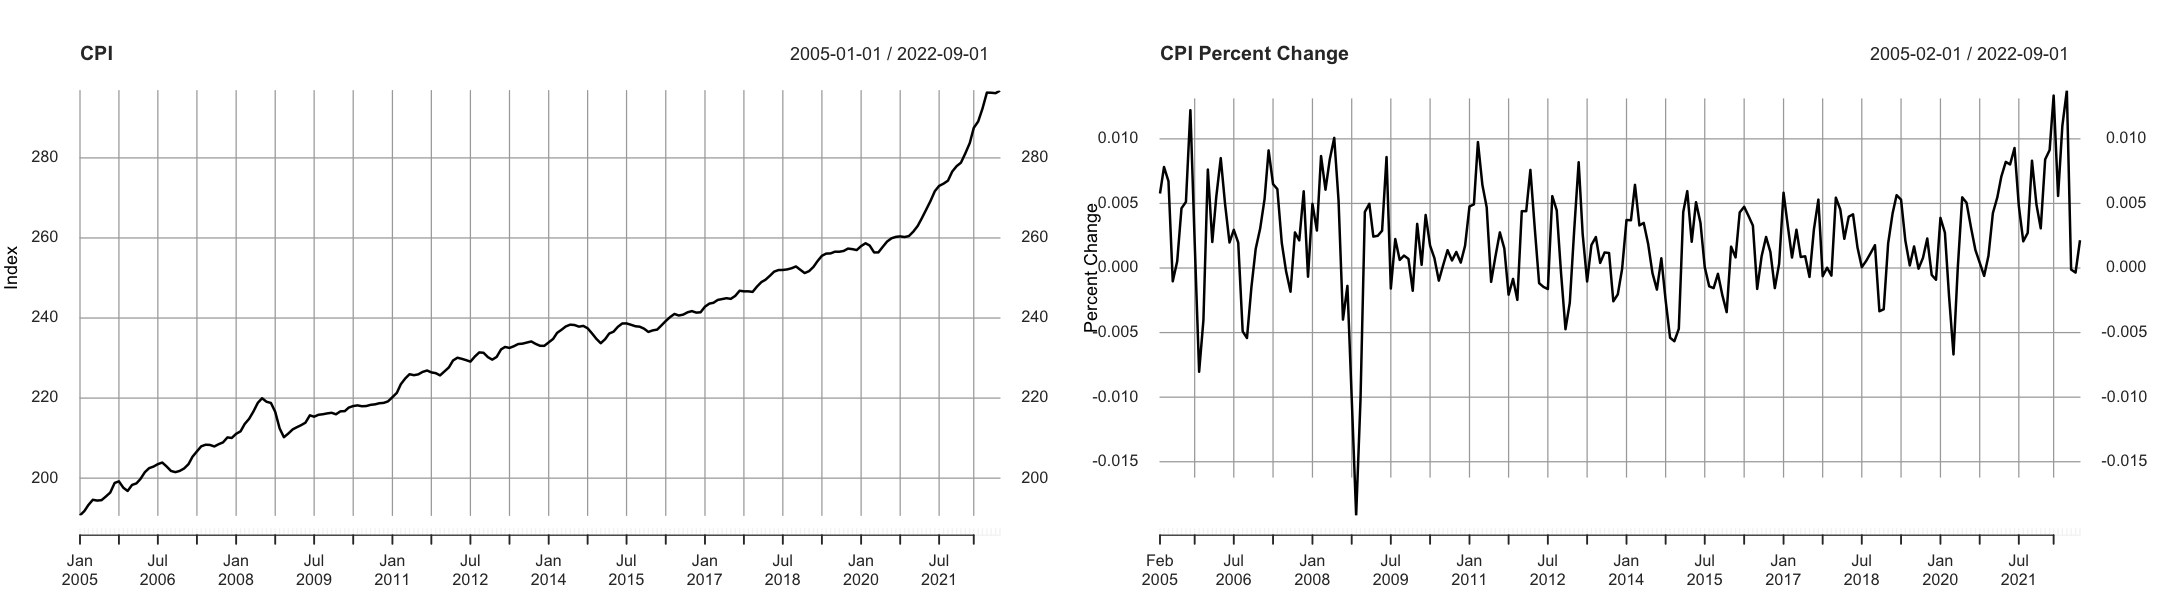

In [5]:
df = read.csv('data/CPI.csv')
cpi = df$All.items %>% xts(order.by = ymd(df$Date))
names(cpi) = 'cpi'

options(repr.plot.width = 18, repr.plot.height = 5)
par(mfcol = c(1,2))
plot(cpi, main = 'CPI', ylab = 'Index')
plot(pct_change(cpi), main = 'CPI Percent Change', ylab = 'Percent Change')


1. Very Stong trend in the original data, there does seem to be some seasonality as well. 

# Trend Estimation
---
1. Splines Regression

In [6]:
np_trend = function(x){
    # if x is a ts object, convert it to an xts object
    require(mgcv)
    n = c(1:nrow(x))
    model = gam(x ~ s(n))
    data.frame(value = x, estimate = fitted(model)) %>% xts(order.by  = index(x))
    }

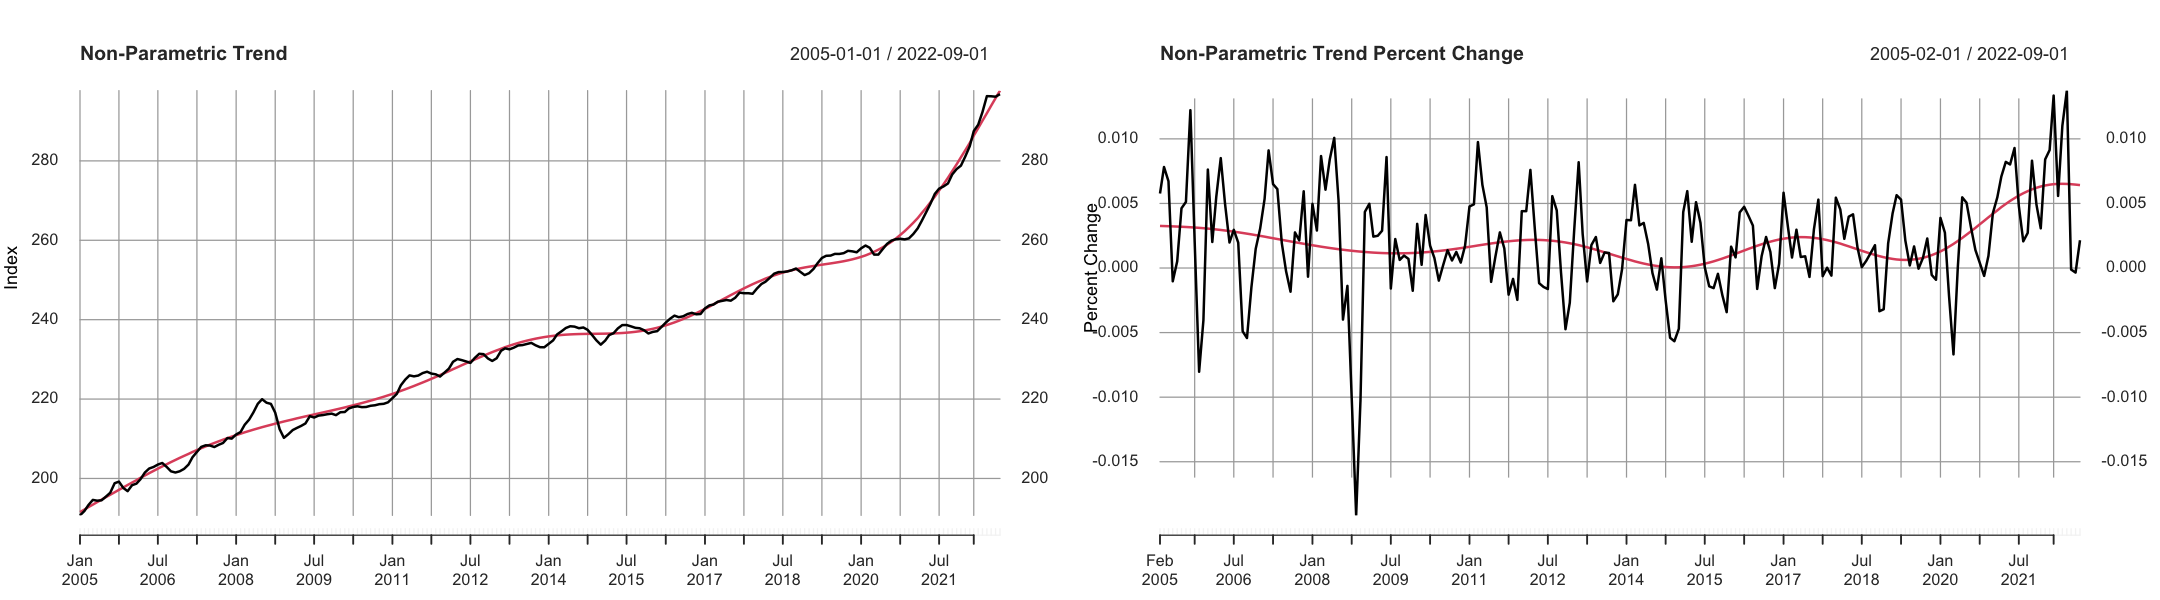

In [7]:
par(mfcol = c(1,2))
plot(np_trend(cpi), main = 'Non-Parametric Trend', ylab = 'Index')
plot(pct_change(np_trend(cpi)), main = 'Non-Parametric Trend Percent Change', ylab = 'Percent Change')

# Arima Modeling 
Max order for p, and q = 4

In [15]:
# Iterative ARIMA Model
arima_iter = function(x, max_order){
    max_order = max_order + 1
    p = c(1: max_order) -1 # 0, 1, 2, ..., max_order
    q = c(1: max_order) -1
    aic = array(0, dim = c(max_order, max_order, 2)) # Create 8x8x2 array
    n = nrow(x)

    # Iterate over d, p, q 
    for (d in 1:2){ # d = d 
        for(i in 1:max_order){ # i = p 
            for(j in 1:max_order){ # j = q
                model = arima(x, order = c(p[i], d, q[j]), method = 'ML', optim.control = list(maxit = 1000)) %>% suppressWarnings()
                aic[i,j,d] = model$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
                #cat('Iterating through model: ',"p = ", p[i],", d = ", d, ", q = ", q[j], ", AICc = ", aic[i,j,d] , '\n') # PRINT ORDER AND AIC CHECK 
            }
        }
    }

    # Find the minimum AICp
    best_ind = which(aic == min(aic), arr.ind = TRUE) # Best model index = (p, q, d)

    p_ind = best_ind[1] - 1
    q_ind = best_ind[2] - 1
    d_ind = best_ind[3]
            return(rbind(BestModel = c(p = p_ind, d = d_ind, q = q_ind, AICc = aic[best_ind])))
}

cpi_arima = arima_iter(cpi, 5)
cpi_pct_arima = arima_iter(pct_change(cpi), 5)
rbind(c('og',cpi_arima), c('pct_change', cpi_pct_arima))

og,4,2,4,505.663079256239
pct_change,5,1,3,-1800.50044122009


In [23]:
fh = 4
train = pct_change(cpi[1:(nrow(cpi)-fh)])
test = pct_change(cpi[(nrow(cpi)-fh+1):nrow(cpi)])

cpi_arima = arima(train, order = c(5,1,3), method = 'ML', optim.control = list(maxit = 1000))
cpi_arima %>% summary()


Call:
arima(x = train, order = c(5, 1, 3), method = "ML", optim.control = list(maxit = 1000))

Coefficients:
         ar1      ar2      ar3     ar4      ar5      ma1     ma2     ma3
      1.1896  -0.5487  -0.0155  0.1381  -0.2015  -1.5193  0.5469  0.0397
s.e.  0.6643   0.9463   0.4963  0.1497   0.0873   0.6793  1.1826  0.5341

sigma^2 estimated as 1.067e-05:  log likelihood = 890.19,  aic = -1762.38

Training set error measures:
                      ME        RMSE         MAE      MPE     MAPE      MASE
Training set 8.51248e-05 0.003258817 0.002450809 130.2252 224.4985 0.8449787
                      ACF1
Training set -0.0007891914

Split data 

In [24]:
cpi_arima = arima(pct_change(cpi[]), order = c(5,1,3), seasonal = list(order = c(0,1,1), period = 12), method = 'ML', optim.control = list(maxit = 1000)) 
cpi_arima %>% summary()


Call:
arima(x = pct_change(cpi[]), order = c(5, 1, 3), seasonal = list(order = c(0, 
    1, 1), period = 12), method = "ML", optim.control = list(maxit = 1000))

Coefficients:
         ar1      ar2     ar3      ar4      ar5      ma1     ma2      ma3
      0.4566  -1.1082  0.5569  -0.2287  -0.0026  -0.8378  0.9023  -0.9415
s.e.  0.0809   0.0778  0.1185   0.0788   0.0784   0.0433  0.0315   0.0418
         sma1
      -0.8817
s.e.   0.0718

sigma^2 estimated as 8.928e-06:  log likelihood = 861.34,  aic = -1702.69

Training set error measures:
                       ME        RMSE         MAE      MPE    MAPE      MASE
Training set 0.0002590353 0.002894901 0.002095172 185.4777 287.417 0.7133804
                     ACF1
Training set -0.008908227


	Box-Ljung test

data:  residuals_in
X-squared = 11.326, df = 20, p-value = 0.9373


	Box-Ljung test

data:  residuals_in^2
X-squared = 25.186, df = 20, p-value = 0.1944



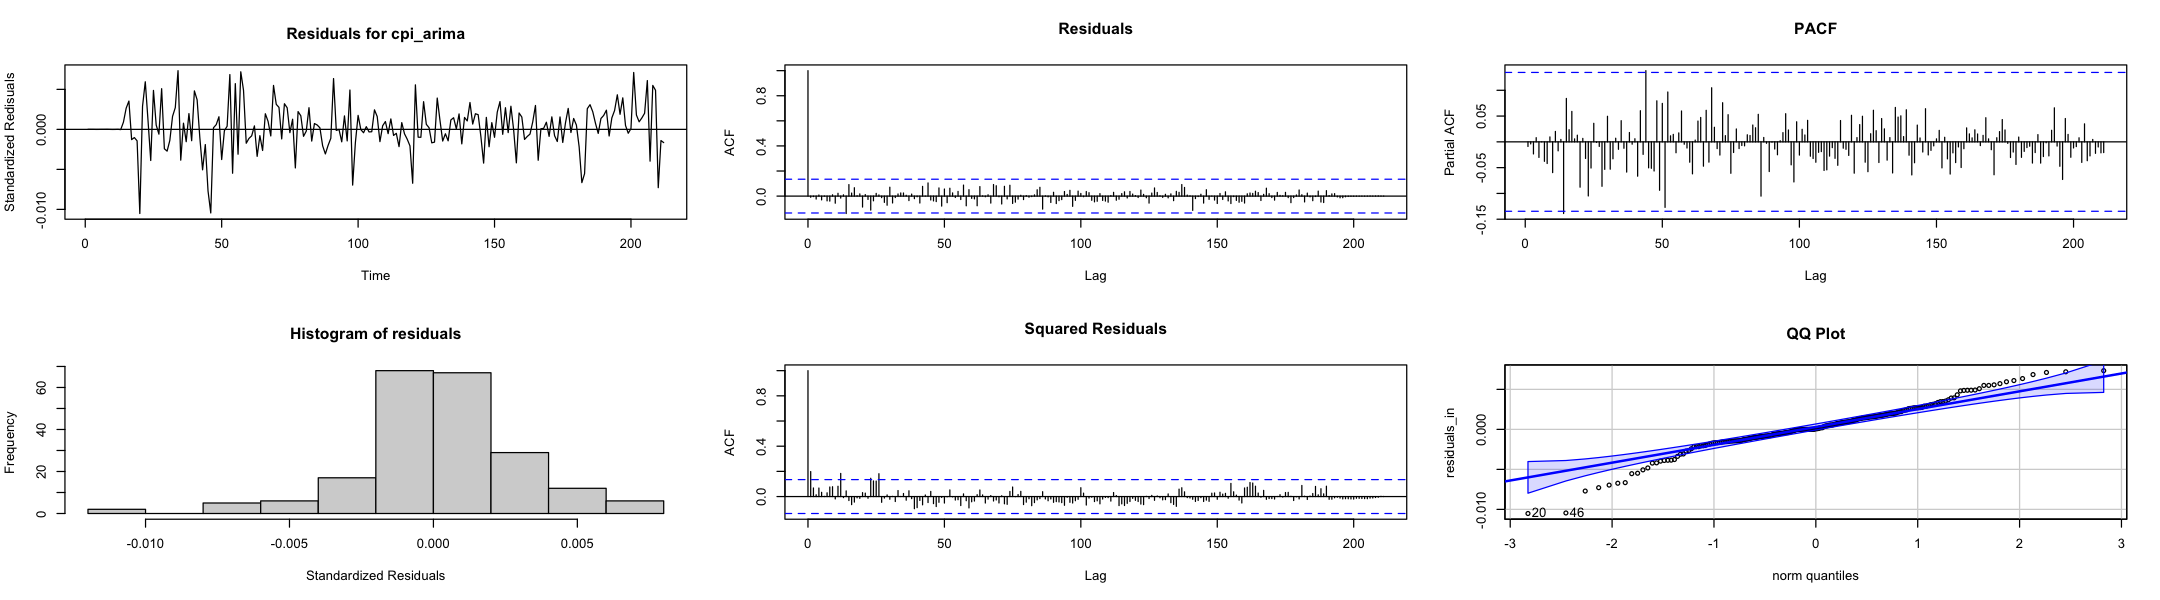

In [25]:
resid_check = function(mod){# Residual Analysis 
    par(mfcol = c(2,3))
    mname = deparse(substitute(mod))
    residuals_in = residuals(mod)
    plot(residuals_in, ylab = 'Standardized Redisuals', main = paste0('Residuals for ', mname))
    abline(h = 0 )
    hist(residuals_in, xlab = 'Standardized Residuals', main = 'Histogram of residuals')
    plot(acf(residuals_in,lag.max = 66*4 ,plot = F),main = 'Residuals')  
    plot(acf(residuals_in^2,lag.max = 66*4 ,plot = F),main = 'Squared Residuals')
    plot(pacf(residuals_in,lag.max = 66*4 ,plot = F),main = 'PACF') 
    qqnorm_vals = car::qqPlot(residuals_in, main = 'QQ Plot')
    print(Box.test(residuals_in, lag = 20, type = 'Ljung-Box'))
    print(Box.test(residuals_in^2, lag = 20, type = 'Ljung-Box'))
}

resid_check(cpi_arima)

# ARIMA prediction

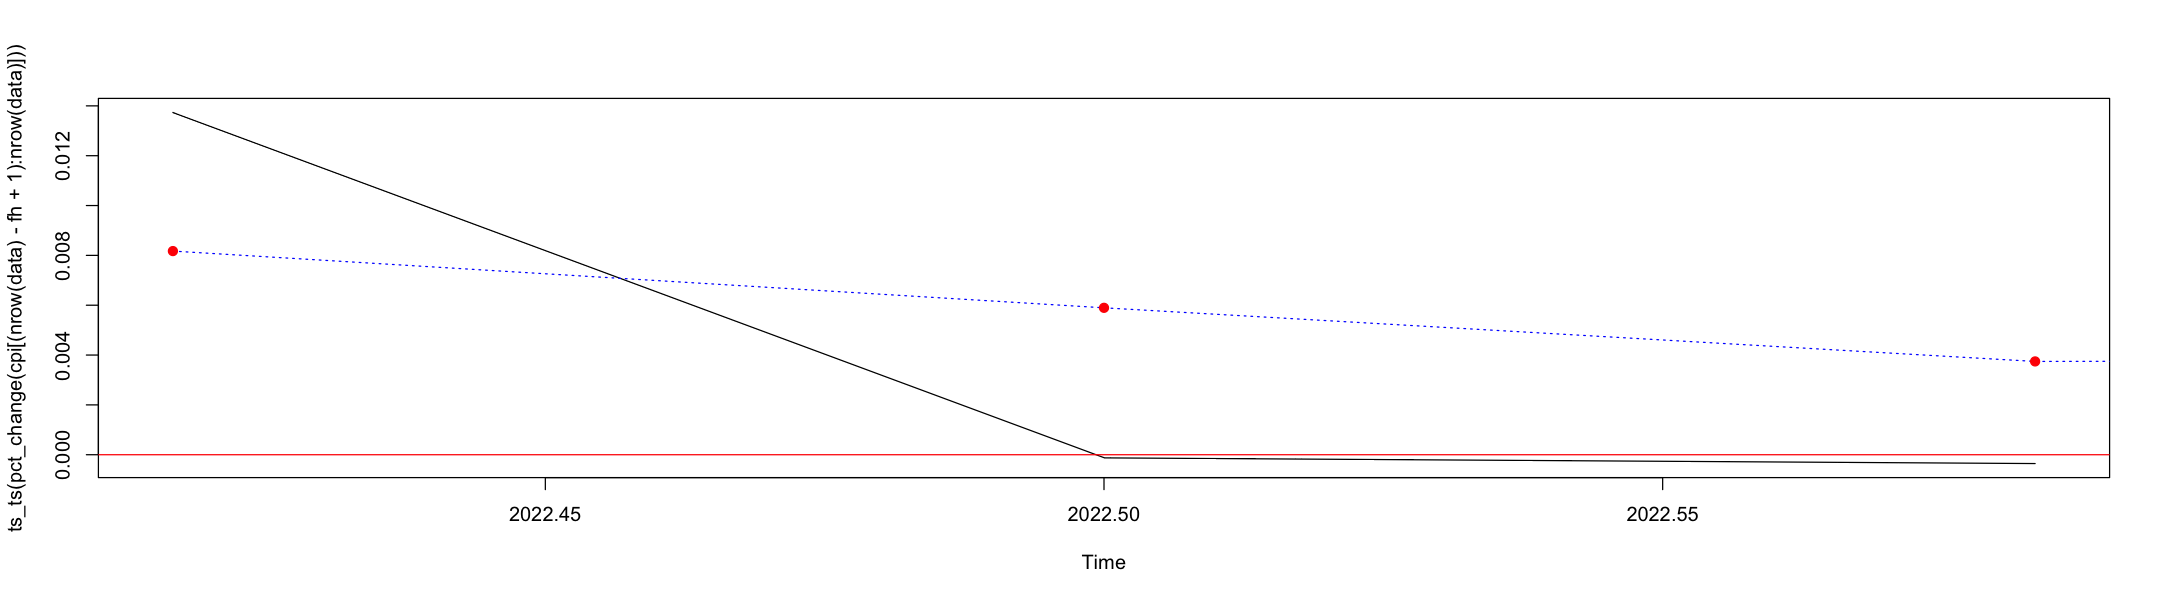

In [93]:
data = pct_change(cpi)
fh = 4
train = data[1:(nrow(data)-fh)]
test = data[(nrow(data)-fh+1):nrow(data)]

cpi_arima = arima(train, order = c(4,1,3), method = 'ML', optim.control = list(maxit = 1000))

# Forecast
cpi_pred_test = predict(cpi_arima, n.ahead = fh)
cpi_pred_test = cpi_pred_test$pred %>% xts(order.by = index(test))
cpi_bounds = cpi_pred_test %>% cbind(cpi_pred_test + 1.96*cpi_arima$sigma, cpi_pred_test - 1.96*cpi_arima$sigma) %>% xts(order.by = index(test)) %>% na.omit()

plot(ts_ts(pct_change(cpi[(nrow(data)-fh+1):nrow(data)])))
lines(ts_ts(cpi_pred_test), col = 'blue', pch= 19, lty = 3)
points(ts_ts(cpi_bounds), col = 'red', pch = 19, lty = 3)
abline(0,0, col = 'red')